In [1]:
import numpy as np 
import pandas as pd
import json
from mplsoccer.pitch import Pitch, VerticalPitch


path = "C:/Users/brand/desktop/events/events_England.json" 

with open(path) as f:
    data = json.load(f)

train = pd.DataFrame(data)


path2 = "C:/Users/brand/desktop/players.json" 


with open(path2) as f:
    play = json.load(f)

players = pd.DataFrame(play)

lst = ['events_France.json','events_Germany.json','events_Italy.json','events_Spain.json']
pathway = "C:/Users/brand/desktop/events/"

for country in lst:
    with open(pathway + country) as f:
        datal = json.load(f)
        tl = pd.DataFrame(datal)
        train = pd.concat([train,tl],ignore_index=True)




#pd.unique(train['subEventName'])
shots = train[train['subEventName'] == 'Shot']

print(len(shots))

shots_model = pd.DataFrame(columns=["Goal","X","Y"], dtype=object)

for i,shot in shots.iterrows():
    
    
    shots_model.at[i,'Header'] = 0
    for tag in shot['tags']:
        if tag['id'] == 403:
            shots_model.at[i,'Header'] = 1
    
    
    #take distance from center of goal at y = 50, x position of goal is always 100
    shots_model.at[i,'X'] = 100-shot['positions'][0]['x']
    shots_model.at[i,'Y'] = shot['positions'][0]['y']
    shots_model.at[i,'C'] = abs(shot['positions'][0]['y'] - 50)
        
    #distance in meters
        
    x = shots_model.at[i,'X']* 105/100
    y = shots_model.at[i,'C']* 65/100
    shots_model.at[i,'Distance'] = np.sqrt(x**2 + y**2)
        
    angle = np.arctan(7.32 * x / (x**2 + y**2 - (7.32/2)**2))
        
    if angle < 0:
        angle = np.pi + angle
        
    shots_model.at[i,'Angle'] = angle
        
    #goal check
    shots_model.at[i,'Goal'] = 0
    shots_model.at[i,'Counter Attack'] = 0
    shots_model.at[i, 'Blocked'] = 0
    shots_model.at[i, 'Right Foot'] = 0
    shots_model.at[i,'wyId'] = shot['playerId']
    
    if shot['matchPeriod'] == '1H':
        shots_model.at[i, 'First Half'] = 1
    
    else:
        shots_model.at[i,'First Half'] = 0
        
    for tags in shot['tags']:
        if tags['id'] == 101:
            shots_model.at[i,'Goal'] = 1
            
        if tags['id'] == 1901:
            shots_model.at[i, 'Counter Attack'] = 1
        
        if tags['id'] == 2101:
            shots_model.at[i, 'Blocked'] = 1
        
        if tags['id'] == 402:
            shots_model.at[i, 'Right Foot'] = 1
            
            
        
shots_model['angle_degrees'] = shots_model['Angle'] * 180 / np.pi

shots_model = shots_model.merge(players, left_on = 'wyId' , right_on = 'wyId')

for i,shot in shots_model.iterrows():
    shots_model.at[i, 'strong foot'] = 0
    
    if shot['Right Foot'] == 1:
        if shot['foot'] == 'right':
            shots_model.at[i, 'strong foot'] = 1
    
    elif shot['Right Foot'] == 0:
        if shot['foot'] == 'left':
            shots_model.at[i, 'strong foot'] = 1


pitch = Pitch(pitch_color ='black', line_color = 'white', stripe=False,pitch_type='wyscout')

fig,ax = pitch.draw(figsize=(10,8))

df = shots_model.loc[shots_model['Goal'] == 1]
xpos = df["X"]
ypos = df["Y"]

df_nongoals = shots_model.loc[shots_model['Goal'] == 0]
xpos2 = df_nongoals["X"]
ypos2 = df_nongoals["Y"]



head = shots_model[shots_model['Header'] == 1]
counter = shots_model[shots_model['Counter Attack'] == 1]
strong = shots_model[shots_model['strong foot'] == 1]
first = shots_model[shots_model['First Half'] == 1]
head_df = head.loc[head['Goal'] == 1]
strong_goal = strong.loc[strong['Goal'] == 1]

headed_goals = len(head_df)

C:\Users\brand\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


40461


In [2]:
from sklearn.model_selection import train_test_split

X_full = shots_model[["Header","Distance", "Angle","Counter Attack","strong foot", "First Half"]]
y_full = shots_model[["Goal"]]
y_full['Goal'] = y_full['Goal'].astype(int)
print(X_full.head())

X_train,X_test,y_train,y_test = train_test_split(X_full,y_full,test_size = 0.15,random_state=2)

X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.176, random_state=2)


print(len(X_train))
print(len(X_val))
print(len(X_test))
print(X_train.head())
print(y_train.head())


   Header   Distance     Angle  Counter Attack  strong foot  First Half
0     0.0  13.891814  0.474451             0.0          1.0         1.0
1     0.0  13.711765  0.519737             0.0          1.0         1.0
2     0.0  14.778701  0.358683             0.0          0.0         0.0
3     0.0  15.243113  0.337590             0.0          1.0         0.0
4     0.0  19.602296  0.357062             0.0          1.0         1.0
28336
6053
6069
       Header   Distance     Angle  Counter Attack  strong foot  First Half
29930     0.0  14.311010  0.415932             0.0          1.0         0.0
18307     0.0  12.666886  0.560177             0.0          0.0         1.0
17403     0.0  18.891929  0.241328             0.0          1.0         1.0
21423     0.0  32.711848  0.221779             0.0          1.0         1.0
18506     0.0  11.200893  0.601170             0.0          0.0         1.0
       Goal
29930     0
18307     0
17403     0
21423     0
18506     0


C:\Users\brand\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [3]:
y_val = np.array(y_val)
yval = [i[0] for i in y_val]
y_test = np.array(y_test)
ytest = [i[0] for i in y_test]
y_train = np.array(y_train)
ytrain = [i[0] for i in y_train]
print(len(y_train))

28336


In [4]:
"""Logistic Regression + validation of regularization parameter"""

'Logistic Regression + validation of regularization parameter'

In [5]:
from sklearn.linear_model import LogisticRegression


lambdas = [0.1**i for i in range(-1,5)]
accs = []

for i in lambdas:
    model = LogisticRegression(C=i).fit(X_train,y_train)
    predictions = model.predict(X_val)
    
    correct = [(p==l) for (p,l) in zip(predictions,yval)]
    
    accuracy = sum(correct)/len(correct)
    accs.append(accuracy)
    
    
    
    
    
print(accs)   

[0.9017016355526185, 0.9017016355526185, 0.9020320502230299, 0.9005451842061788, 0.896745415496448, 0.8954237568148026]


In [6]:
"""Highest Accuracy with lambda = 1"""

'Highest Accuracy with lambda = 1'

In [7]:
"""Check Balanced error rates, precision, ROC"""
import matplotlib.pyplot as plt


lambs = [1,.01,.001,.0001,.00001]
f1 = []
prec = []
rec = []
ber = []
acc = []
for i in lambs:
    log = LogisticRegression(C=i).fit(X_train,ytrain)
    predictions = log.predict(X_val)
    
    TP = sum([(p and l) for (p,l) in zip(predictions, yval)])
    FP = sum([(p and not l) for (p,l) in zip(predictions, yval)])
    TN = sum([(not p and not l) for (p,l) in zip(predictions, yval)])
    FN = sum([(not p and l) for (p,l) in zip(predictions, yval)])
    
    accuracy = (TP + TN)/(TP + FP + TN + FN)
    
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    
    BER = 1 - .5 * (TPR + TNR)
    
    precision = TP/(TP+FP)
    recall = TP/(TP + FN)
    
    F1 = 2 * (precision*recall)/(precision + recall)
    
    f1.append(F1)
    prec.append(precision)
    rec.append(recall)
    ber.append(BER)
    acc.append(accuracy)

    

C:\Users\brand\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\brand\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


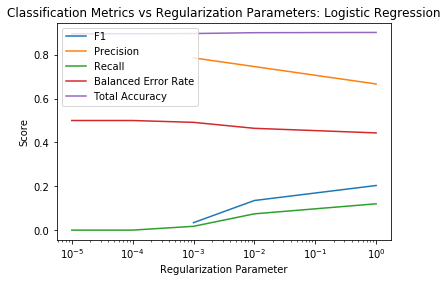

In [8]:

plt.xlabel('Regularization Parameter')
plt.xscale('log')
plt.ylabel('Score')
plt.title('Classification Metrics vs Regularization Parameters: Logistic Regression')
plt.plot(lambs,f1,label='F1')
plt.plot(lambs,prec,label='Precision')
plt.plot(lambs,rec,label='Recall')
plt.plot(lambs,ber,label='Balanced Error Rate')
plt.plot(lambs,acc,label = 'Total Accuracy')
plt.legend(loc=2)
plt.show()



In [25]:
"""ROC lambda = 1: Highest BER"""

X_val = np.array(X_val)

bestlog = LogisticRegression(C=1,class_weight='balanced').fit(X_train,ytrain)
probs = bestlog.predict_proba(X_val)
prediction = bestlog.predict(X_val)

probY = list(zip([p[1] for p in probs], [p[1] > 0.5 for p in probs], yval))

probY.sort(reverse=True)
print(probY[0:30])



[(0.9975703325103313, True, 1), (0.997443610868391, True, 1), (0.9960452053799259, True, 1), (0.9960452053799259, True, 1), (0.9924154997171999, True, 1), (0.9924154997171999, True, 0), (0.9917108524975875, True, 1), (0.9915647859380068, True, 1), (0.9908768411994824, True, 1), (0.9905701069654334, True, 1), (0.9905701069654334, True, 1), (0.9905701069654334, True, 0), (0.9896957914308361, True, 1), (0.9892493089605826, True, 1), (0.9882539845394647, True, 0), (0.987417062164754, True, 1), (0.987417062164754, True, 0), (0.985661025750038, True, 1), (0.984338748970321, True, 0), (0.9814947365178995, True, 0), (0.980364350905937, True, 0), (0.9785642604990074, True, 1), (0.9779792571088302, True, 1), (0.9776463416960885, True, 1), (0.9776463416960885, True, 1), (0.9775846696752535, True, 1), (0.9755361119852513, True, 1), (0.9755006943237484, True, 0), (0.9720782354761258, True, 1), (0.9720782354761258, True, 0)]


In [26]:
"""Performance on Test Set"""

'Performance on Test Set'

In [27]:
test_predictions = bestlog.predict(X_test)

TP = sum([(p and l) for (p,l) in zip(test_predictions, ytest)])
FP = sum([(p and not l) for (p,l) in zip(test_predictions, ytest)])
TN = sum([(not p and not l) for (p,l) in zip(test_predictions, ytest)])
FN = sum([(not p and l) for (p,l) in zip(test_predictions, ytest)])
    
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
    
BER = 1 - .5 * (TPR + TNR)
    
precision = TP/(TP+FP)
recall = TP/(TP + FN)
    
F1 = 2 * (precision*recall)/(precision + recall)

accuracy = (TP + TN)/(TP + FP + TN + FN)
    
print("Balanced Error rate: " + str(BER))
print("Precision: " + str(precision))
print('Recall: ' + str(recall))
print('F1 score: ' + str(F1))
print('Total Classification Accuracy: ' + str(accuracy))
print()

print(bestlog.coef_)

Balanced Error rate: 0.28070927669805656
Precision: 0.23774765380604795
Recall: 0.7080745341614907
F1 score: 0.3559718969555035
Total Classification Accuracy: 0.7281265447355413

[[-0.91391737 -0.08952894  2.17268448  0.56032656  0.13241954 -0.08955069]]


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
0.11533839279297464
Coeffs
[0.49687647]
0.0839128583681029
0.11533839279297464


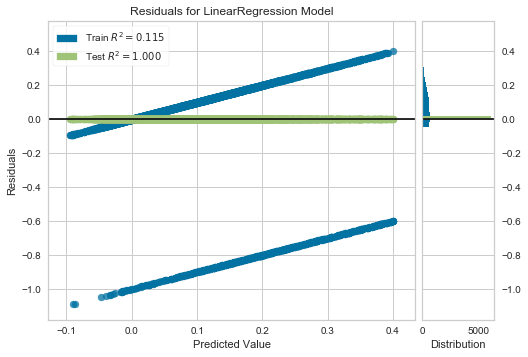

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot


xtestprobs = bestlog.predict_proba(X_test)[:,1]

Y = []
X = []
count1 = 0
count2 = 0
for i in range(len(xtestprobs)):
    count1 += xtestprobs[i]
    count2 += ytest[i]
    
    
    X.append(count1)
    Y.append(count2)
    count1 = 0
    count2 = 0

print(Y[0:10])
X = np.array(X)
X = X.reshape(-1,1)



lin = LinearRegression().fit(X,Y)

print(lin.score(X,Y))

lpreds = lin.predict(X)
print('Coeffs')
print(lin.coef_)

print(mean_squared_error(Y,lpreds))
print(r2_score(Y,lpreds))


visualizer = ResidualsPlot(lin)
visualizer.fit(X,Y)
visualizer.score(X,lpreds)
visualizer.show()